# 10: MODPATH demonstration

In [1]:
import pathlib as pl
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from flopy.utils.gridintersect import GridIntersect
import flopy

## Groundwater Modeling and Python Programming

In this exercise, we will use MODPATH to simulate advective transport with the Freyberg flow model. For this exercise, we will use a quadtree version of the Freyberg model.

The location of the contamination patch and the nodes that the define bounding cells of the patch are calculated below.

In [2]:
# patch upper left and lower right
xmin, xmax = 250. * 1, 250. * 3
ymin, ymax = (40 - 14) * 250., (40 - 11) * 250. 

csx, csy = [xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin]
polygon = [list(zip(csx, csy))]
(xmin, ymax), (xmax, ymin)

((250.0, 7250.0), (750.0, 6500.0))

--------------------------

### Define the workspace and model names.

In [3]:
load_ws = pl.Path('data/quadtree')
ws = pl.Path("temp/ex10a")
name = "project"
name_mp = f"{name}_mp"
exe_name = 'mf6'

## Load the MODFLOW 6 Model

Load a simulation object using `flopy.mf6.MFSimulation().load()`.

In [4]:
sim = flopy.mf6.MFSimulation.load(sim_name=name, exe_name=exe_name,
                                    sim_ws=load_ws, verbosity_level=0)

### Load the groundwater flow model

In [5]:
gwf = sim.get_model(name)
gwf.modelgrid

xll:0.0; yll:0.0; rotation:0.0; units:meters; lenuni:2

### Change the workspace

In [6]:
sim.set_sim_path(ws)

### Write the model files

In [7]:
sim.write_simulation()

Run the simulation.

In [8]:
sim.run_simulation()

(True, [])

## Create and Run the MODPATH model


### Lets plot the model grid and the location of the contamination patch.

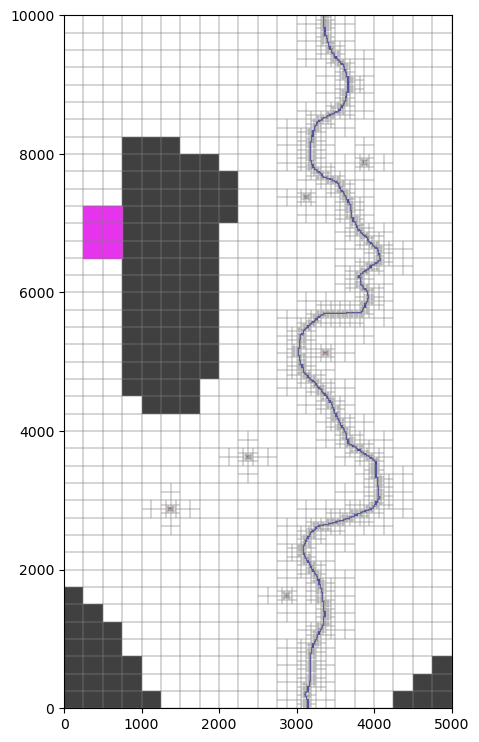

In [9]:
fig, ax = plt.subplots(figsize=(5, 9))
mm = flopy.plot.PlotMapView(gwf, layer=0, ax=ax)

mm.plot_bc('SFR', color="b", plotAll=True)
mm.plot_bc('WEL', plotAll=True)
mm.plot_inactive(alpha=0.75)

mm.plot_grid(lw=0.25, color='grey')

ax.fill(csx, csy, color='#e534eb');

Find the node numbers of the contamination patch using the groundwater model grid object and the `GridIntersect` utility. The `GridIntersect` utility has an `intersect` method that can be used to identified cellids from points, lines, and polygons.

In [10]:
gx = GridIntersect(gwf.modelgrid)
results = gx.intersect(polygon, 'Polygon')
nodes = results.cellids
nodes

array([1352, 1353, 1459, 1460, 1581, 1582], dtype=object)

### Create the MODPATH particle data

In [11]:
# create
sd = flopy.modpath.CellDataType()
p = flopy.modpath.NodeParticleData(subdivisiondata=[sd],
                                   nodes=list(nodes))
# create forward particle group
fpth = name_mp + '.sloc'
pg = flopy.modpath.ParticleGroupNodeTemplate(particlegroupname='contaminant',
                                             particledata=p,
                                             filename=fpth)

### Create the MODPATH 7 files

In [12]:
# create modpath files
mp = flopy.modpath.Modpath7(modelname=name_mp, flowmodel=gwf,
                            exe_name='mp7', model_ws=ws)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=0.1)
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='pathline', 
                                  trackingdirection='forward',
                                  weaksinkoption='pass_through',
                                  weaksourceoption='pass_through',
                                  referencetime=0.,
                                  stoptimeoption='extend',
                                  particlegroups=pg)

### Write MODPATH 7 files and run the model

In [13]:
# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

FloPy is using the following executable to run the model: ../../../../../../software/modflow_exes/mp7

MODPATH Version 7.2.001   
Program compiled Aug 01 2021 12:57:00 with IFORT compiler (ver. 19.10.3)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
       162 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

## Post-Process the MODFLOW and MODPATH Results


### Load MODFLOW and MODPATH results from the heads and pathline files

Load the MODFLOW heads

In [14]:
hobj = gwf.output.head()

In [15]:
hds = hobj.get_data()

Load the pathline file

In [16]:
ppth =ws / f"{name_mp}.mppth"
p = flopy.utils.PathlineFile(ppth)
p0 = p.get_alldata()
pd.DataFrame(p0[0]).head()

x            y          z          time  k  particleid
0  291.666656  7041.666504  25.157747      0.000000  0           0
1  292.265228  7053.434082  24.259151   1066.623169  0           0
2  296.871582  7187.314941  18.867577   9176.828125  1           0
3  298.295715  7250.000000  17.837860  11656.656250  2           0
4  327.380127  7500.000000  17.041315  17482.574219  2           0

### Plot the heads and pathlines

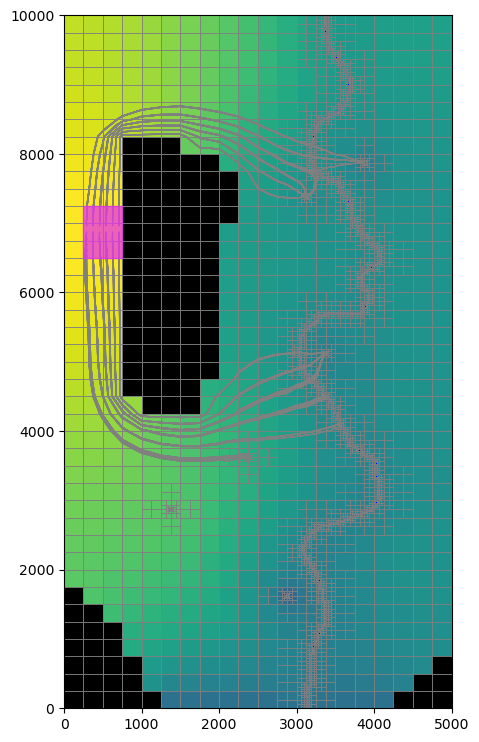

In [17]:
fig, ax = plt.subplots(figsize=(5, 9))
mm = flopy.plot.PlotMapView(model=gwf, layer=0, ax=ax)
mm.plot_array(hds, masked_values=[1e30])

mm.plot_bc('SFR', color='b', plotAll=True)
mm.plot_bc('WEL', plotAll=True)
mm.plot_ibound()
mm.plot_pathline(p0, layer='all', color='blue', edgecolor="None", lw=0.75)
mm.plot_grid(lw=0.5, color="0.5")

ax = plt.gca()
ax.fill(csx, csy, color='#e534eb', zorder=100, alpha=.75);

### Export the pathlines to a shapefile

In [18]:
spth = pl.Path(ws / 'pathline.shp')
p.write_shapefile(p0, mg=gwf.modelgrid, one_per_particle=False, shpname=spth)

{'names': ['x', 'y', 'z', 'time', 'k', 'particleid'], 'formats': ['<f4', '<f4', '<f4', '<f4', '<i4', '<i4'], 'offsets': [20, 24, 28, 16, 32, 0], 'itemsize': 60}
No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.


### Load the shapefile into geopandas

In [19]:
rshp = gpd.read_file(spth)

/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)


### Show the dataframe

In [20]:
rshp.head()

/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs 

x            y          z          time  k  particleid  \
0  292.265228  7053.434082  24.259151   1066.623169  1           1   
1  296.871582  7187.314941  18.867577   9176.828125  2           1   
2  298.295715  7250.000000  17.837860  11656.656250  3           1   
3  327.380127  7500.000000  17.041315  17482.574219  3           1   
4  351.953125  7750.000000  14.886883  21403.548828  3           1   

                                          geometry  
0  LINESTRING (291.667 7041.667, 292.265 7053.434)  
1  LINESTRING (292.265 7053.434, 296.872 7187.315)  
2  LINESTRING (296.872 7187.315, 298.296 7250.000)  
3  LINESTRING (298.296 7250.000, 327.380 7500.000)  
4  LINESTRING (327.380 7500.000, 351.953 7750.000)

### Plot the geopandas dataframe on the modelgrid

/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)


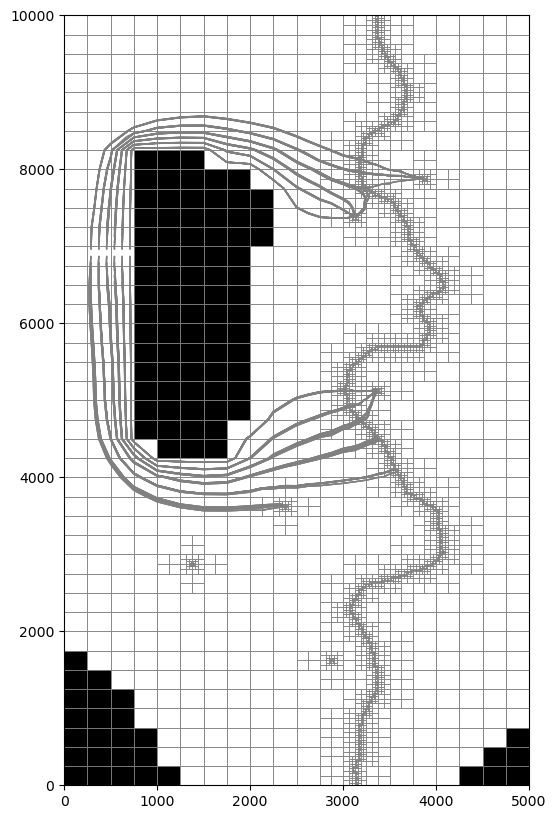

In [21]:
fig, ax = plt.subplots(figsize=(6, 10))
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
pmv.plot_grid(lw=0.5)
pmv.plot_shapes(rshp.geometry.to_list(), edgecolor="grey") #, edgecolor="b")
pmv.plot_ibound();